In [ ]:
!pip uninstall -y numpy pandas
!pip install numpy==1.26.4 pandas==2.2.2 --force-reinstall
!pip install pygam transformers wordfreq


Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: pandas 2.2.2
Uninstalling pandas-2.2.2:
  Successfully uninstalled pandas-2.2.2
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached pandas-2.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached six-1.17.0-py2.py3-none-any.whl.metadata (1.7 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
Using cached pandas-2.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.0 MB)
Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl (229 kB)
Using cached pytz-2025.2-py2.py3-

  Using cached pygam-0.9.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached wordfreq-3.1.1-py3-none-any.whl.metadata (27 kB)
  Using cached scipy-1.11.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached ftfy-6.3.1-py3-none-any.whl.metadata (7.3 kB)
  Using cached locate-1.1.1-py3-none-any.whl.metadata (3.9 kB)
Using cached pygam-0.9.1-py3-none-any.whl (522 kB)
Using cached wordfreq-3.1.1-py3-none-any.whl (56.8 MB)
Using cached ftfy-6.3.1-py3-none-any.whl (44 kB)
Using cached locate-1.1.1-py3-none-any.whl (5.4 kB)
Using cached scipy-1.11.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (36.4 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 req

In [ ]:

import os
import pandas as pd
from wordfreq import word_frequency

# Clone the OneStop-Eye-Movements repository (contains download script)
if not os.path.isdir('../OneStop-Eye-Movements'):
    !git clone https://github.com/lacclab/OneStop-Eye-Movements.git

# Run the download script from the repo root
!python OneStop-Eye-Movements/download_data_files.py --mode ordinary --extract --output-folder data/OneStop

# Locate and load ia_Paragraph_ordinary.csv
csv_path = None
for root, dirs, files in os.walk('../data/OneStop'):
    for f in files:
        if f.lower().startswith('ia_paragraph') and f.endswith('.csv'):
            csv_path = os.path.join(root, f)
            break
    if csv_path: break

if csv_path is None:
    raise FileNotFoundError("ia_Paragraph_ordinary.csv not found in downloaded data.")

df = pd.read_csv(csv_path)
print(f"Loaded data with {len(df)} rows and columns: {list(df.columns)}")

import torch
import math
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM
import numpy as np

# Load tokenizer and model
model_name = "EleutherAI/pythia-70m"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def extract_words_with_offsets(text):
    word_spans = []
    cursor = 0
    for word in text.split():
        begin = text.find(word, cursor)
        finish = begin + len(word)
        word_spans.append((word, begin, finish))
        cursor = finish
    return word_spans

def compute_word_surprisal(text):
    encoded = tokenizer(text, return_tensors="pt", return_offsets_mapping=True)
    input_ids = encoded["input_ids"].to(device)
    offset_map = encoded["offset_mapping"][0]

    with torch.no_grad():
        logits = model(input_ids).logits
        log_probs = torch.log_softmax(logits, dim=-1)

    surprisals = []
    for i in range(1, input_ids.size(1)):
        token = input_ids[0, i].item()
        token_log_prob = log_probs[0, i - 1, token]
        surprisal_val = -token_log_prob.item() / math.log(2)
        surprisals.append(surprisal_val)

    word_offsets = extract_words_with_offsets(text)
    word_level_surprisal = []
    token_pointer = 0
    total_tokens = len(surprisals)

    for word, w_start, w_end in word_offsets:
        acc_surprisal = 0.0
        while token_pointer < total_tokens:
            t_start, t_end = offset_map[token_pointer + 1].tolist()
            if t_start >= w_end:
                break
            if t_end <= w_start:
                token_pointer += 1
                continue
            acc_surprisal += surprisals[token_pointer]
            token_pointer += 1
        word_level_surprisal.append((word, acc_surprisal))

    return word_level_surprisal

print("Computing word frequency and length features...")
df['word_length'] = df['IA_LABEL'].str.len()
df['log_frequency'] = df['IA_LABEL'].apply(lambda x: np.log(word_frequency(x.lower(), 'en') + 1e-8))

# Compute surprisal values for each paragraph
print("Computing surprisal values...")
unique_paragraphs = df[['article_batch', 'article_id', 'paragraph_id', 'paragraph']].drop_duplicates()

surprisal_dict = {}
for idx, row in unique_paragraphs.iterrows():
    key = (row['article_batch'], row['article_id'], row['paragraph_id'])
    text = row['paragraph']
    if pd.notna(text):
        word_surprisals = compute_word_surprisal(text)
        surprisal_dict[key] = {word: surp for word, surp in word_surprisals}
    else:
        surprisal_dict[key] = {}

# Map surprisal values to the main dataframe
def get_surprisal(row):
    key = (row['article_batch'], row['article_id'], row['paragraph_id'])
    word = row['IA_LABEL']
    return surprisal_dict.get(key, {}).get(word, np.nan)

df['pythia_surprisal'] = df.apply(get_surprisal, axis=1)

print(f"Computed surprisal for {df['pythia_surprisal'].notna().sum()} words")

Cloning into 'OneStop-Eye-Movements'...
remote: Enumerating objects: 130, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 130 (delta 20), reused 35 (delta 11), pack-reused 62 (from 1)
Receiving objects: 100% (130/130), 15.40 MiB | 16.17 MiB/s, done.
Resolving deltas: 100% (23/23), done.
Extracted ordinary to data/OneStop/ordinary
Extracted ordinary to data/OneStop/ordinary
Loaded data with 1104883 rows and columns: ['participant_id', 'TRIAL_INDEX', 'EYE_REPORTED', 'EYE_TRACKED', 'IA_AREA', 'IA_AVERAGE_FIX_PUPIL_SIZE', 'IA_BOTTOM', 'IA_DWELL_TIME', 'IA_DWELL_TIME_%', 'IA_FIRST_FIXATION_DURATION', 'IA_FIRST_FIXATION_INDEX', 'IA_FIRST_FIXATION_PREVIOUS_FIX_IA', 'IA_FIRST_FIXATION_PREVIOUS_IAREAS', 'IA_FIRST_FIXATION_RUN_INDEX', 'IA_FIRST_FIXATION_TIME', 'IA_FIRST_FIXATION_VISITED_IA_COUNT', 'IA_FIRST_FIXATION_X', 'IA_FIRST_FIXATION_Y', 'IA_FIRST_FIX_PROGRESSIVE', 'IA_FIRST_RUN_DWELL_TIME', 'IA_FIRST_RUN_END_TIME', 'IA_FIRS

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/396 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/567 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/166M [00:00<?, ?B/s]

Computing word frequency and length features...
Computing surprisal values...
Computed surprisal for 975689 words




--- Fitting GAM for IA_DWELL_TIME (current + spillover) ---


100% (11 of 11) |########################| Elapsed Time: 0:01:42 Time:  0:01:42


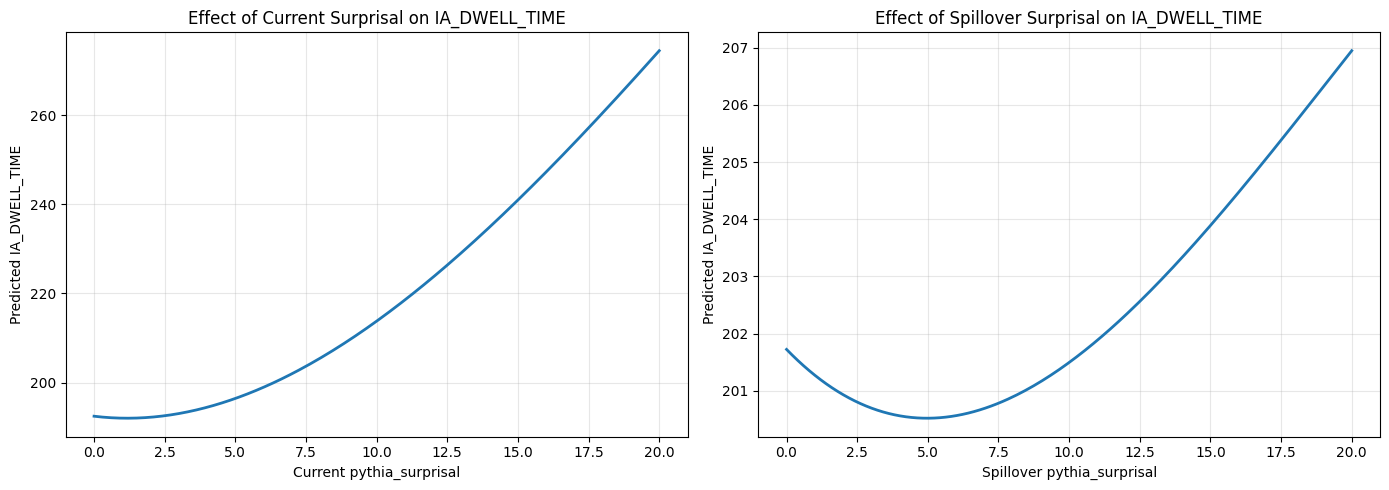



--- Fitting GAM for IA_FIRST_RUN_DWELL_TIME (current + spillover) ---


100% (11 of 11) |########################| Elapsed Time: 0:00:59 Time:  0:00:59


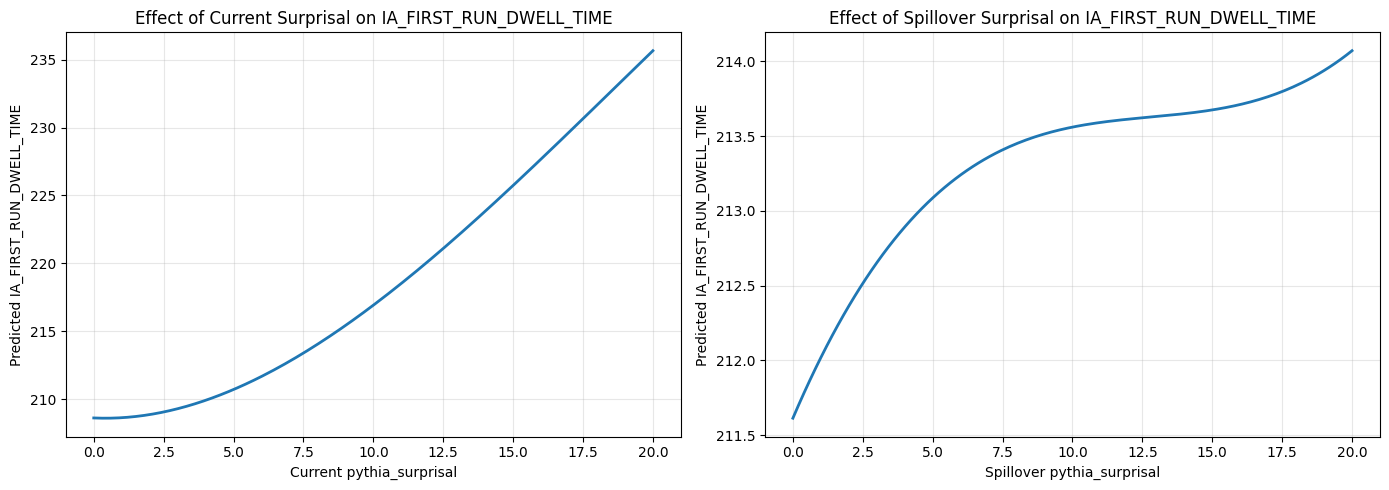



--- Fitting GAM for IA_REGRESSION_PATH_DURATION (current + spillover) ---


100% (11 of 11) |########################| Elapsed Time: 0:00:59 Time:  0:00:59


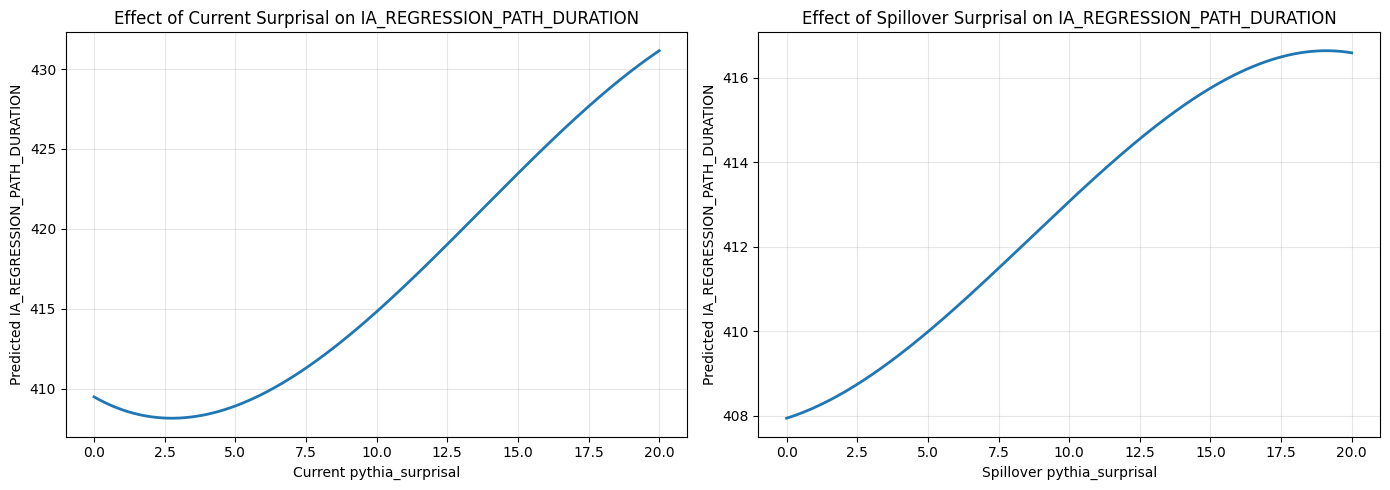

In [ ]:
import numpy as np
import pandas as pd
from pygam import LinearGAM, s
import matplotlib.pyplot as plt

rt_measures = [
    'IA_DWELL_TIME',
    'IA_FIRST_RUN_DWELL_TIME',
    'IA_REGRESSION_PATH_DURATION'
]

# ensure the RTs are numeric
df[rt_measures] = df[rt_measures].apply(pd.to_numeric, errors='coerce')

# compute lag-1 surprisal within each IA_ID
df = (
    df
    .sort_values(['article_batch','article_id','paragraph_id','IA_ID'])
    .assign(
        surprisal_spill = lambda d: d
            .groupby(['article_batch','article_id','paragraph_id'])
            ['pythia_surprisal']
            .shift(1)
    )
)

for rt in rt_measures:
    print(f"\n\n--- Fitting GAM for {rt} (current + spillover) ---")

    # only keep rows with no NAs in any of the four predictors + the DV
    cols = ['pythia_surprisal', 'surprisal_spill', 'word_length', 'log_frequency', rt]
    mdl = df.dropna(subset=cols).copy()

    # design matrix now has 4 predictors
    X = mdl[['pythia_surprisal','surprisal_spill','word_length','log_frequency']].values
    y = mdl[rt].values

    # build a GAM with 4 smooths (~10 df each)
    gam = LinearGAM(
        s(0, n_splines=5, spline_order=3) +   # current surprisal
        s(1, n_splines=5, spline_order=3) +   # spillover surprisal
        s(2, n_splines=5, spline_order=3) +   # word length
        s(3, n_splines=5, spline_order=3),    # log frequency
        fit_intercept=True
    )
    gam.gridsearch(X, y)

    # prepare ranges for partial plots
    cur_range = np.linspace(mdl.pythia_surprisal.min(), min(20, mdl.pythia_surprisal.max()), 200)
    spill_range = np.linspace(mdl.surprisal_spill.min(), min(20, mdl.surprisal_spill.max()), 200)

    mean_len, mean_logf = mdl[['word_length','log_frequency']].mean().values

    # 1) Partial effect of current surprisal (spillover at mean)
    X_cur = np.column_stack([
        cur_range,
        np.full_like(cur_range, mdl.surprisal_spill.mean()),
        np.full_like(cur_range, mean_len),
        np.full_like(cur_range, mean_logf),
    ])
    y_cur = gam.predict(X_cur)

    # 2) Partial effect of spillover surprisal (current at mean)
    X_spill = np.column_stack([
        np.full_like(spill_range, mdl.pythia_surprisal.mean()),
        spill_range,
        np.full_like(spill_range, mean_len),
        np.full_like(spill_range, mean_logf),
    ])
    y_spill = gam.predict(X_spill)

    # plotting
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].plot(cur_range, y_cur, lw=2)
    axes[0].set_xlabel('Current pythia_surprisal')
    axes[0].set_ylabel(f'Predicted {rt}')
    axes[0].set_title(f'Effect of Current Surprisal on {rt}')
    axes[0].grid(alpha=0.3)

    axes[1].plot(spill_range, y_spill, lw=2)
    axes[1].set_xlabel('Spillover pythia_surprisal')
    axes[1].set_ylabel(f'Predicted {rt}')
    axes[1].set_title(f'Effect of Spillover Surprisal on {rt}')
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()
